In [1]:
import numpy as np
import pandas as pd
import skimage
print(skimage.__version__)

0.13.1


In [2]:
!ls

Annotation	datalab   Images      lists	 test
annotation.tar	features  images.tar  lists.tar  train


In [0]:
# FULL RESTART
#!kill -9 -1

# Misc info

In [0]:
url = 'http://vision.stanford.edu/aditya86/ImageNetDogs/'

# Sub-features

In [0]:
#Create folders
import os
def folder_create(path):
    os.makedirs(os.path.join(path), exist_ok=True)

In [0]:
#Dowload files
from six.moves.urllib.request import urlretrieve
def downloadfile(filename, targetloc='.', url=url):
    dest_filename = os.path.join(targetloc, filename)
    filename, _ = urlretrieve(url + filename, dest_filename)
    print(dest_filename, 'created')
    return filename

In [0]:
#Extract files
import tarfile
import sys
def extract(filename, target, location = '.'):
    
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(target)
    tar.close()
    print(filename, 'created')

# dataset preparation

## Folder creation

In [0]:
# Folder creation
folder_create('lists')
folder_create('train')
folder_create('test')
folder_create('features')
folder_create('Annotation')

## downloading

In [10]:
#Datadownloading
downloadfile('lists.tar')
downloadfile('annotation.tar')
downloadfile('images.tar')
#downloadfile('train_data.mat', targetloc = 'features')
#downloadfile('test_data.mat', targetloc = 'features')

./lists.tar created
./annotation.tar created
./images.tar created


'./images.tar'

## Data preparation

In [11]:
#File extraction
extract('lists.tar', target='lists/')
extract('annotation.tar', target='.')
extract('images.tar', target='.')

lists.tar created
annotation.tar created
images.tar created


In [12]:
!ls

Annotation	datalab   Images      lists	 test
annotation.tar	features  images.tar  lists.tar  train


In [13]:
import scipy.io as sio
test_list = sio.loadmat('lists/test_list.mat')
train_list = sio.loadmat('lists/train_list.mat')
test_list.keys()

dict_keys(['__header__', '__version__', '__globals__', 'file_list', 'annotation_list', 'labels'])

In [0]:
from bs4 import BeautifulSoup
from skimage.io import imread, imsave
from skimage import transform

def spreadfiles(listmat, serie=None, annotation='Annotation', images='Images'):
    counter = 0
    for filepath in listmat['file_list']:
        counter +=1
        if counter % 500 == 0:
            print(f'{counter} files done')
        cleanedfilepath = filepath[0][0]
        filename = os.path.split(cleanedfilepath)[-1].split('.')[0]
        foldername = os.path.split(cleanedfilepath)[0]
        details = {}
        with open(os.path.join(annotation, foldername, filename), 'r', encoding='utf-8') as f:
            soup = BeautifulSoup(f, 'html.parser')
            dog = soup.find('object')
            details['xmin'] = int(dog.xmin.string)
            details['xmax'] = int(dog.xmax.string)
            details['ymin'] = int(dog.ymin.string)
            details['ymax'] = int(dog.ymax.string)
            #details['breed'] = dog.find_all('name')[0].string
        #print(os.path.join(images, foldername, f'{filename}.jpg'))
        image_data = imread(os.path.join(images, foldername, f'{filename}.jpg'))
        new_image_data = image_data[details['ymin']:details['ymax'],details['xmin']:details['xmax'],:]
        newpath = os.path.join(serie, foldername)
        #print(newpath)
        folder_create(newpath)
        try:
            imsave(os.path.join(newpath, f'{filename}.jpg'), new_image_data)
        except:
            print(f'problem with {filename} :-(')


In [15]:
%%time
spreadfiles(test_list, serie='test')



500 files done
1000 files done
1500 files done
2000 files done
2500 files done
3000 files done
3500 files done
4000 files done
4500 files done
5000 files done
5500 files done
6000 files done
6500 files done
7000 files done
7500 files done
8000 files done
8500 files done
CPU times: user 1min 50s, sys: 1.45 s, total: 1min 52s
Wall time: 1min 52s


In [16]:
%%time
spreadfiles(train_list, serie='train')

500 files done
1000 files done
1500 files done
2000 files done
2500 files done
3000 files done
3500 files done
4000 files done
4500 files done
5000 files done
5500 files done
6000 files done
6500 files done
7000 files done
7500 files done
8000 files done
8500 files done
9000 files done
9500 files done
10000 files done
10500 files done
11000 files done
11500 files done
12000 files done
CPU times: user 2min 37s, sys: 1.92 s, total: 2min 39s
Wall time: 2min 39s


# VGG16

In [3]:
import numpy as np
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
print(keras.__version__)

Using TensorFlow backend.


2.1.6


In [0]:
image_size = 224
num_class = 120
batch_size = 32
num_channels = 3
train_data_dir = 'train'
validation_data_dir = 'test'

In [0]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import os

In [6]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(#rotation_range=40,
                                   #shear_range=0.2,
                                   #channel_shift_range=20,
                                   #width_shift_range=0.2,
                                   #height_shift_range=0.2,
                                   #zoom_range=0.2,
                                   #horizontal_flip=True,
                                   #rescale=1./255,
                                    )

test_datagen = ImageDataGenerator() #rescale=1./255

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(image_size,image_size),
                                                    class_mode='categorical',
                                                    batch_size=batch_size)

validation_generator = test_datagen.flow_from_directory(validation_data_dir, 
                                                        target_size=(image_size,image_size),
                                                        class_mode='categorical',
                                                        batch_size=batch_size)

Found 12000 images belonging to 120 classes.
Found 8580 images belonging to 120 classes.


## Baseline

In [0]:
baseline = VGG16(weights='imagenet')
#baseline.summary()

In [20]:
pred = []
for img_path in validation_generator.filenames:
    img = image.load_img(os.path.join(validation_generator.directory, img_path), target_size=(image_size, image_size))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0) #To add a dimension
    x = preprocess_input(x)

    preds = baseline.predict(x)
    readable = decode_predictions(preds, top=1)[0][0]
    code, breed, acc = decode_predictions(preds, top=1)[0][0]
    # decode the results into a list of tuples (class, description, probability)
    pred.append(validation_generator.class_indices.get(f'{code}-{breed}',-1))
    #print('Predicted:', readable)
pred[:10]

40960/35363 [==================================] - 0s 1us/step


[0, 0, 0, 0, 0, 0, 0, 0, -1, 0]

In [21]:
from sklearn.metrics import accuracy_score
accuracy_score(validation_generator.classes, pred)

0.803962703962704

In [22]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
generator = datagen.flow_from_directory(train_data_dir, 
                                                        target_size=(image_size,image_size),
                                                        class_mode=None,
                                                        batch_size=batch_size,
                                                       shuffle=False)

preds = baseline.predict_generator(generator)

Found 12000 images belonging to 120 classes.


In [23]:
import pandas as pd

df = pd.DataFrame({'120cl':generator.classes,
                   '1000cl':np.argmax(preds,axis=1)})
df.head()

1000cl  120cl
0     151      0
1     151      0
2     151      0
3     728      0
4     151      0

In [26]:
baseline.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [24]:
#Index in which I'm interrested
newindex = df.groupby('120cl').agg(lambda x:x.value_counts().index[0])['1000cl'].tolist()
df.groupby('120cl').agg(lambda x:x.value_counts().index[0]).head()

1000cl
120cl        
0         151
1         152
2         153
3         154
4         155

In [0]:
#Weights from complete model
originalweights = baseline.get_layer('predictions').get_weights()
fc1weights = baseline.get_layer('fc1').get_weights()
fc2weights = baseline.get_layer('fc2').get_weights()

In [29]:
weight = originalweights[0][:,np.array(newindex)]
weight.shape

(4096, 120)

In [30]:
bias = originalweights[1][newindex]
bias.shape

(120,)

In [0]:
dogweight = [weight, bias]

## Transfer learning - Bottlneck

In [0]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
import math

In [0]:
tr_model=VGG16(include_top=False,
               weights='imagenet',
               input_shape = (224, 224, 3),
                 ) #
#tr_model.summary()

In [9]:
tr_model.input_shape

(None, 224, 224, 3)

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
datagen = ImageDataGenerator(rescale=1. / 255,
                             preprocessing_function=preprocess_input,
                             )

In [11]:
# training set
train_generator = datagen.flow_from_directory(train_data_dir,
                                                    target_size=(image_size,image_size),
                                                    class_mode=None,
                                                    batch_size=batch_size,
                                                    shuffle=False)

nb_train_samples = len(train_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
bottleneck_features_train = tr_model.predict_generator(train_generator, predict_size_train) #
train_labels = to_categorical(train_generator.classes , num_classes=num_class)

Found 12000 images belonging to 120 classes.


In [12]:
# Validation set
validation_generator = datagen.flow_from_directory(validation_data_dir, 
                                                        target_size=(image_size,image_size),
                                                        class_mode=None,
                                                        batch_size=batch_size,
                                                        shuffle=False)

nb_validation_samples = len(validation_generator.filenames)
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

bottleneck_features_validation = tr_model.predict_generator(validation_generator, predict_size_validation) #
validation_labels = to_categorical(validation_generator.classes, num_classes=num_class)

Found 8580 images belonging to 120 classes.


In [13]:
print(bottleneck_features_train.shape)
print(bottleneck_features_validation.shape)

(12000, 7, 7, 512)
(8580, 7, 7, 512)


In [14]:
print(train_labels.shape)
print(validation_labels.shape)

(12000, 120)
(8580, 120)


In [36]:
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, regularizers
model = Sequential()
model.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
model.add(Dropout(0.6))
model.add(Dense(2048, activation='relu', name='fc1'))
model.add(BatchNormalization(name='norm1'))
model.add(Dropout(0.5))
model.add(Dense(2048, activation='relu', name='fc2'))
model.add(BatchNormalization(name='norm2'))
model.add(Dropout(0.3))


model.add(Dense(num_class, activation='softmax', name='pred'))

model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 2048)              51382272  
_________________________________________________________________
norm1 (BatchNormalization)   (None, 2048)              8192      
_________________________________________________________________
dropout_11 (Dropout)         (None, 2048)              0         
_________________________________________________________________
fc2 (Dense)                  (None, 2048)              4196352   
_________________________________________________________________
norm2 (BatchNormalization)   (None, 2048)              8192      
__________

In [0]:
#model.get_layer('pred').set_weights(dogweight)
#model.get_layer('fc1').set_weights(fc1weights)
#model.get_layer('fc2').set_weights(fc2weights)

In [0]:
# Freeze the layers which you don't want to train. 
#for layer in model.layers[::-1]:
#    if layer.name in ['pred', 'fc2', 'norm']:
#        layer.trainable = True
#        print('trainable  --> ', layer.name)
#    else:
#        print('NOT trainable  --> ', layer.name)
#        layer.trainable = False

In [39]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=4, verbose=1, mode='auto')

history = model.fit(bottleneck_features_train, train_labels,
          epochs=30,
          batch_size=batch_size,
          validation_data=(bottleneck_features_validation, validation_labels),
                   callbacks = [early])

Train on 12000 samples, validate on 8580 samples
Epoch 1/30
12000/12000 [==============================] - 18s 2ms/step - loss: 5.5984 - acc: 0.0188 - val_loss: 4.1210 - val_acc: 0.0874
Epoch 2/30
12000/12000 [==============================] - 17s 1ms/step - loss: 4.7905 - acc: 0.0497 - val_loss: 3.5763 - val_acc: 0.1679
Epoch 3/30
 2816/12000 [======>.......................] - ETA: 11s - loss: 4.3209 - acc: 0.0781

12000/12000 [==============================] - 17s 1ms/step - loss: 4.2618 - acc: 0.0882 - val_loss: 3.2235 - val_acc: 0.2300
Epoch 4/30
12000/12000 [==============================] - 17s 1ms/step - loss: 3.8663 - acc: 0.1268 - val_loss: 2.8942 - val_acc: 0.2695
Epoch 5/30
 8224/12000 [===================>..........] - ETA: 4s - loss: 3.6104 - acc: 0.1588

12000/12000 [==============================] - 17s 1ms/step - loss: 3.5914 - acc: 0.1633 - val_loss: 2.7056 - val_acc: 0.3008
Epoch 6/30
12000/12000 [==============================] - 17s 1ms/step - loss: 3.3743 - acc: 0.1933 - val_loss: 2.5506 - val_acc: 0.3369
Epoch 7/30
 9472/12000 [======================>.......] - ETA: 3s - loss: 3.1615 - acc: 0.2230

12000/12000 [==============================] - 17s 1ms/step - loss: 3.1468 - acc: 0.2264 - val_loss: 2.4524 - val_acc: 0.3543
Epoch 8/30
12000/12000 [==============================] - 17s 1ms/step - loss: 2.9860 - acc: 0.2530 - val_loss: 2.3307 - val_acc: 0.3734
Epoch 9/30
 9792/12000 [=======================>......] - ETA: 2s - loss: 2.8515 - acc: 0.2727

12000/12000 [==============================] - 17s 1ms/step - loss: 2.8585 - acc: 0.2732 - val_loss: 2.2882 - val_acc: 0.3829
Epoch 10/30
12000/12000 [==============================] - 17s 1ms/step - loss: 2.7659 - acc: 0.2937 - val_loss: 2.1946 - val_acc: 0.4066
Epoch 11/30
 9760/12000 [=======================>......] - ETA: 2s - loss: 2.6715 - acc: 0.3154

12000/12000 [==============================] - 17s 1ms/step - loss: 2.6639 - acc: 0.3143 - val_loss: 2.1625 - val_acc: 0.4031
Epoch 12/30
12000/12000 [==============================] - 17s 1ms/step - loss: 2.5277 - acc: 0.3448 - val_loss: 2.0950 - val_acc: 0.4255
Epoch 13/30
 9664/12000 [=======================>......] - ETA: 2s - loss: 2.4799 - acc: 0.3514

12000/12000 [==============================] - 17s 1ms/step - loss: 2.4667 - acc: 0.3528 - val_loss: 2.1019 - val_acc: 0.4233
Epoch 14/30
12000/12000 [==============================] - 17s 1ms/step - loss: 2.3793 - acc: 0.3742 - val_loss: 2.0396 - val_acc: 0.4353
Epoch 15/30
 9728/12000 [=======================>......] - ETA: 2s - loss: 2.3022 - acc: 0.3882

12000/12000 [==============================] - 17s 1ms/step - loss: 2.3108 - acc: 0.3850 - val_loss: 1.9901 - val_acc: 0.4494
Epoch 16/30
12000/12000 [==============================] - 17s 1ms/step - loss: 2.2706 - acc: 0.3995 - val_loss: 1.9867 - val_acc: 0.4471
Epoch 17/30
 9728/12000 [=======================>......] - ETA: 2s - loss: 2.1958 - acc: 0.4076

12000/12000 [==============================] - 17s 1ms/step - loss: 2.2029 - acc: 0.4074 - val_loss: 1.9974 - val_acc: 0.4492
Epoch 18/30
12000/12000 [==============================] - 17s 1ms/step - loss: 2.1466 - acc: 0.4202 - val_loss: 1.9311 - val_acc: 0.4667
Epoch 19/30
 9760/12000 [=======================>......] - ETA: 2s - loss: 2.0623 - acc: 0.4415

12000/12000 [==============================] - 17s 1ms/step - loss: 2.0668 - acc: 0.4404 - val_loss: 1.9435 - val_acc: 0.4582
Epoch 20/30
12000/12000 [==============================] - 17s 1ms/step - loss: 2.0257 - acc: 0.4478 - val_loss: 1.9530 - val_acc: 0.4582
Epoch 21/30
 9696/12000 [=======================>......] - ETA: 2s - loss: 1.9795 - acc: 0.4542

12000/12000 [==============================] - 17s 1ms/step - loss: 1.9774 - acc: 0.4578 - val_loss: 1.8976 - val_acc: 0.4713
Epoch 22/30
12000/12000 [==============================] - 17s 1ms/step - loss: 1.9163 - acc: 0.4758 - val_loss: 1.8977 - val_acc: 0.4741
Epoch 23/30
 9728/12000 [=======================>......] - ETA: 2s - loss: 1.8561 - acc: 0.4905

12000/12000 [==============================] - 17s 1ms/step - loss: 1.8648 - acc: 0.4885 - val_loss: 1.9193 - val_acc: 0.4697
Epoch 24/30
12000/12000 [==============================] - 17s 1ms/step - loss: 1.8387 - acc: 0.4876 - val_loss: 1.8774 - val_acc: 0.4829
Epoch 25/30
 9664/12000 [=======================>......] - ETA: 2s - loss: 1.7699 - acc: 0.5001

12000/12000 [==============================] - 17s 1ms/step - loss: 1.7747 - acc: 0.5021 - val_loss: 1.9384 - val_acc: 0.4684
Epoch 26/30
12000/12000 [==============================] - 17s 1ms/step - loss: 1.7368 - acc: 0.5129 - val_loss: 1.8836 - val_acc: 0.4794
Epoch 27/30
 9760/12000 [=======================>......] - ETA: 2s - loss: 1.7012 - acc: 0.5218

12000/12000 [==============================] - 17s 1ms/step - loss: 1.7052 - acc: 0.5197 - val_loss: 1.9086 - val_acc: 0.4692
Epoch 28/30
12000/12000 [==============================] - 17s 1ms/step - loss: 1.6552 - acc: 0.5362 - val_loss: 1.8401 - val_acc: 0.4907
Epoch 29/30
 9696/12000 [=======================>......] - ETA: 2s - loss: 1.6160 - acc: 0.5404

12000/12000 [==============================] - 17s 1ms/step - loss: 1.6173 - acc: 0.5386 - val_loss: 1.8677 - val_acc: 0.4840
Epoch 30/30
12000/12000 [==============================] - 17s 1ms/step - loss: 1.6031 - acc: 0.5482 - val_loss: 1.8607 - val_acc: 0.4851


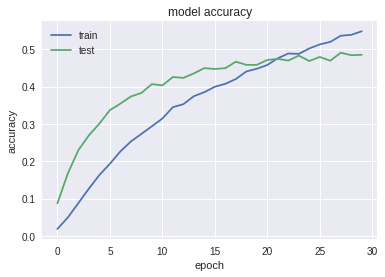

In [40]:
import matplotlib.pyplot as plt
import numpy

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

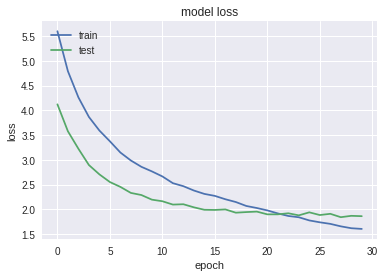

In [41]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Data analysis

In [0]:
pred_probas = model.predict(bottleneck_features_validation)

In [0]:
#Misc value
maxval = [arr[index] for arr, index in zip(pred_probas, np.argsort(pred_probas, axis=1)[:,-1])]
predict = np.argsort(pred_probas, axis=1)[:,-1]
secondval = [arr[index] for arr, index in zip(pred_probas, np.argsort(pred_probas, axis=1)[:,-2])]

In [0]:
indexlabel = {v:k[10:] for k,v in train_generator.class_indices.items()}

In [45]:
import pandas as pd
resultset = pd.DataFrame(data=pred_probas, columns = range(len(indexlabel)))
resultset = pd.concat([resultset, pd.DataFrame(data={'True': validation_generator.classes,
                                                     'maxval' : maxval,
                                                     'predict': predict,
                                                     'secondval': secondval,
                                                     #'breedname': X_test.breedname.tolist(),
                                                     'filepath': validation_generator.filenames})], axis=1)
resultset['correct'] = resultset['True'] == resultset['predict']
resultset['breedname'] = resultset['True'].apply(lambda x: indexlabel.get(x, -1))
resultset['diff'] = resultset['maxval'] - resultset['secondval']
resultset.head()

0         1             2         3         4         5         6  \
0  0.189236  0.000015  6.442291e-07  0.000010  0.000004  0.000122  0.003408   
1  0.809493  0.000139  7.871077e-06  0.000013  0.000034  0.001663  0.023334   
2  0.098115  0.000115  3.366590e-06  0.000008  0.000001  0.000051  0.001998   
3  0.204778  0.002058  1.340656e-02  0.009400  0.001322  0.000377  0.001192   
4  0.694365  0.000004  5.610813e-03  0.000036  0.000032  0.000047  0.000113   

          7             8             9    ...              118           119  \
0  0.048345  3.734402e-07  3.327243e-08    ...     1.876651e-05  3.660800e-05   
1  0.059838  1.005815e-06  4.011503e-07    ...     1.269522e-04  1.562088e-04   
2  0.005360  1.246501e-07  5.764382e-07    ...     1.392528e-03  5.331604e-05   
3  0.021725  3.227774e-04  8.967408e-06    ...     7.520774e-03  2.968400e-04   
4  0.255422  3.610786e-06  3.086272e-08    ...     7.235062e-07  1.070207e-07   

   True                                 filepath    maxval  predict  \
0     0  n02085620-Chihuahua/n02085620_10074.jpg  0.698070      111   
1     0  n02085620-Chihuahua/n02085620_10131.jpg  0.809493        0   
2     0   n02085620-Chihuahua/n02085620_1073.jpg  0.469060       99   
3     0  n02085620-Chihuahua/n02085620_11337.jpg  0.204778        0   
4     0  n02085620-Chihuahua/n02085620_11477.jpg  0.694365        0   

   secondval  correct  breedname      diff  
0   0.189236    False  Chihuahua  0.508834  
1   0.059838     True  Chihuahua  0.749655  
2   0.194909    False  Chihuahua  0.274151  
3   0.083908     True  Chihuahua  0.120869  
4   0.255422     True  Chihuahua  0.438943  

[5 rows x 128 columns]

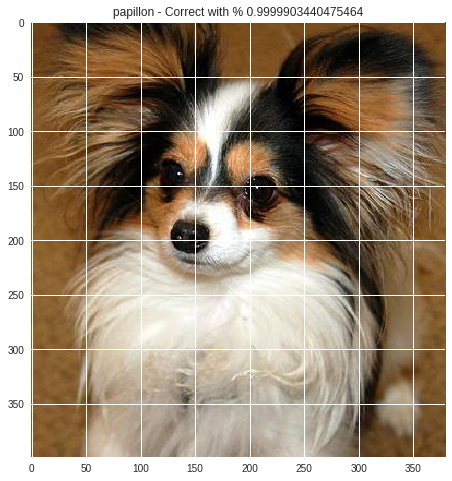

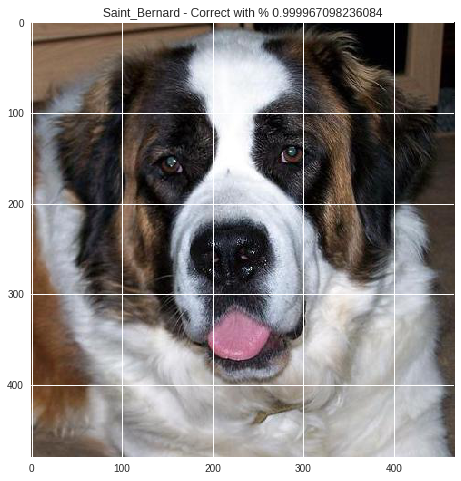

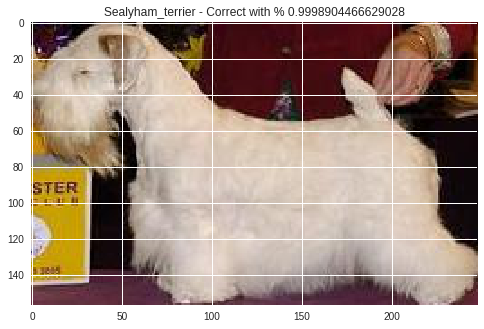

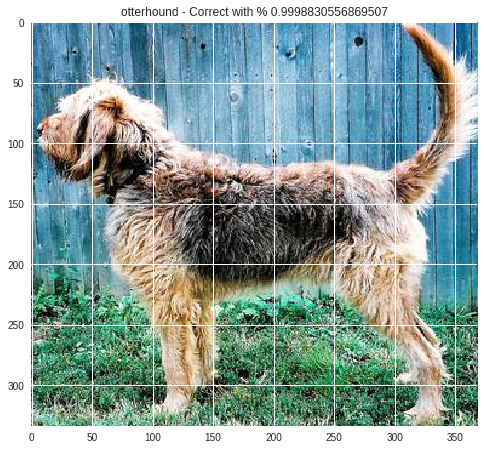

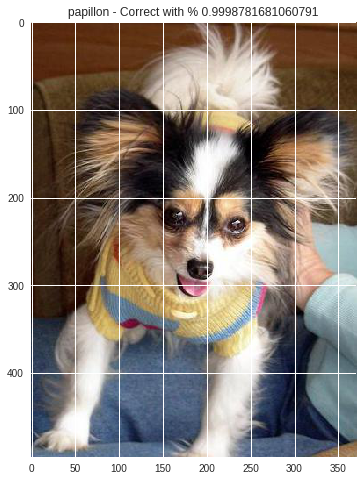

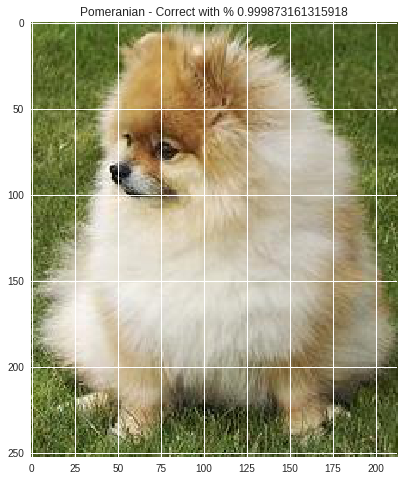

In [46]:
#Most right
import matplotlib.pyplot as plt
from skimage.io import imread
%matplotlib inline
ds = resultset[resultset['correct']]
ds = ds.sort_values('maxval', ascending=False)

for index, line in ds[:10].iterrows():
    toopen = 'test/{}'.format(line.filepath)
    
    if toopen:
        plt.figure(figsize=(8,8))
        picture = imread(toopen)
        plt.imshow(picture)
        plt.title('{} - Correct with % {}'.format(line.breedname, line.maxval))
        plt.show()
    else:
        print('Picture not found')

    #print('{} - Correct with % {}'.format(line.breedname, line.maxval))


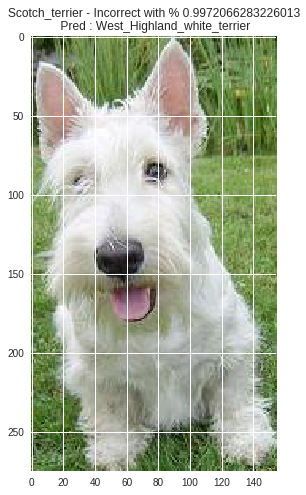

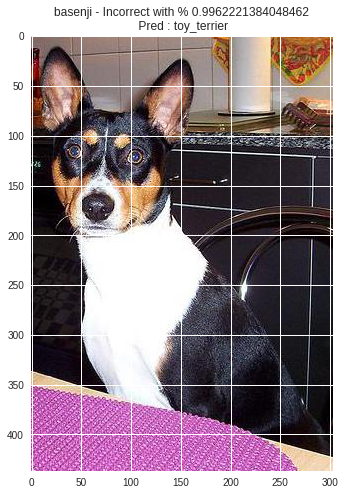

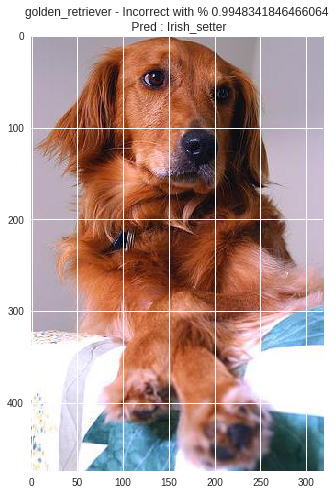

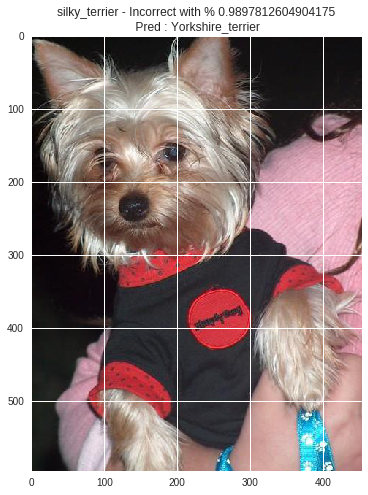

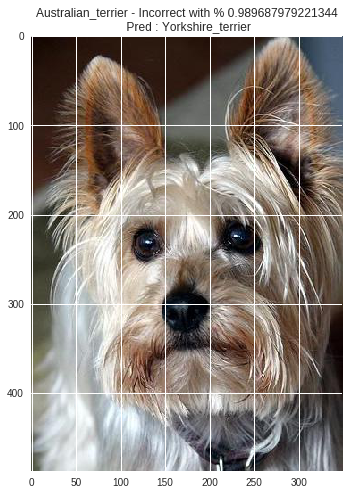

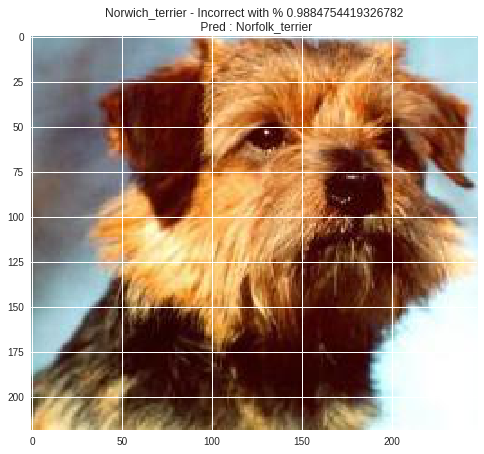

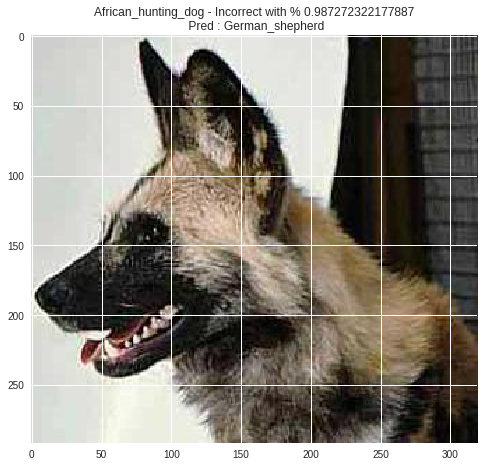

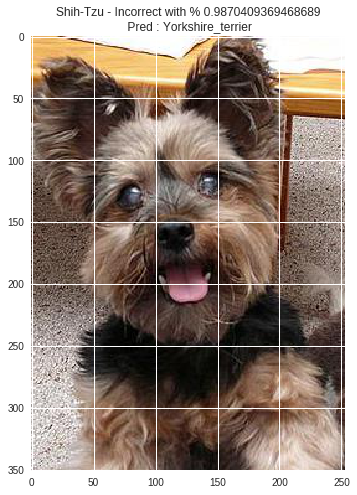

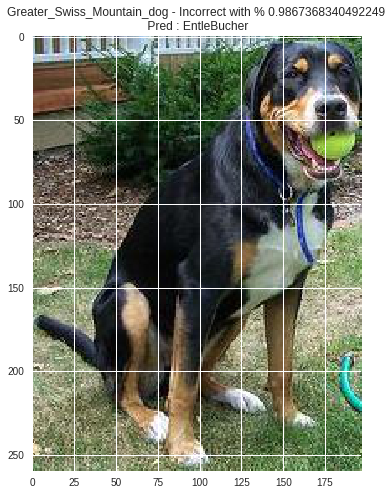

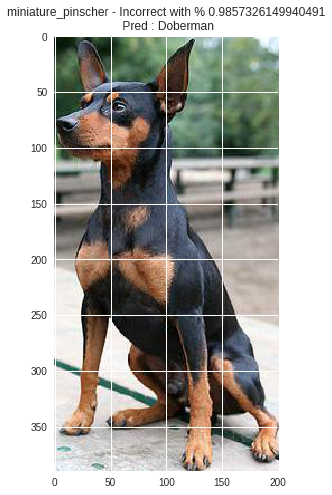

In [47]:
#Most wrong
%matplotlib inline
ds = resultset[np.logical_not(resultset['correct'])]
ds = ds.sort_values('maxval', ascending=False)
for index, line in ds[:10].iterrows():
    toopen = 'test/{}'.format(line.filepath)
    
    if toopen:
        plt.figure(figsize=(8,8))
        picture = imread(toopen)
        plt.imshow(picture)
        plt.title('{} - Incorrect with % {}\n Pred : {}'.format(line.breedname, line.maxval, indexlabel.get(line.predict)))
        plt.show()
    else:
        print('Picture not found')

    #print('{} - Correct with % {}'.format(line.breedname, line.maxval))

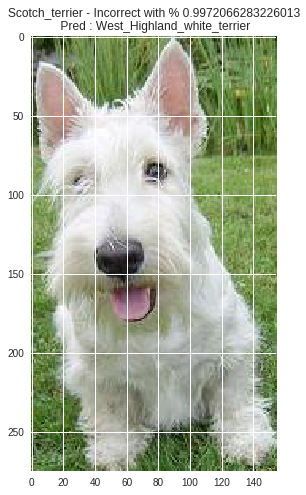

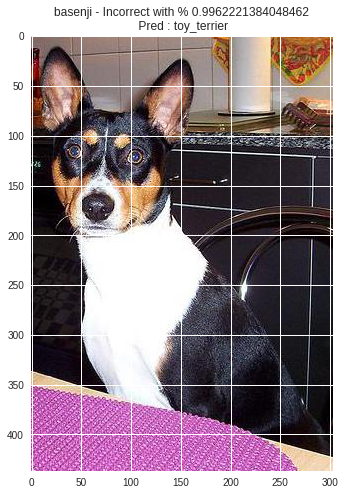

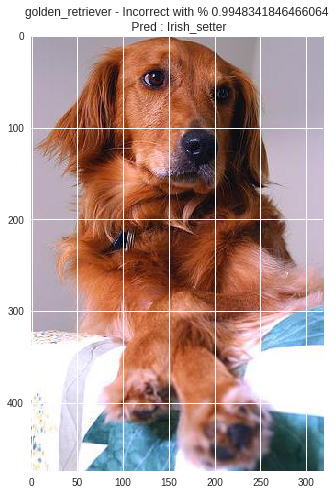

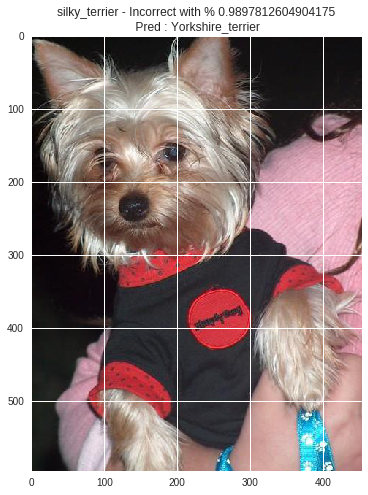

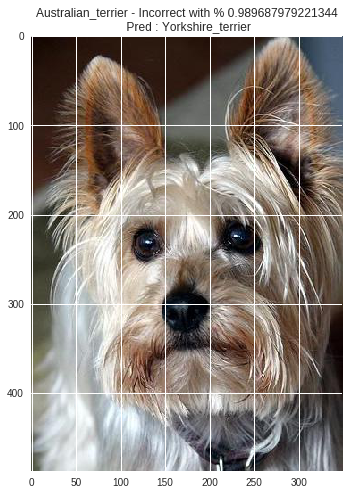

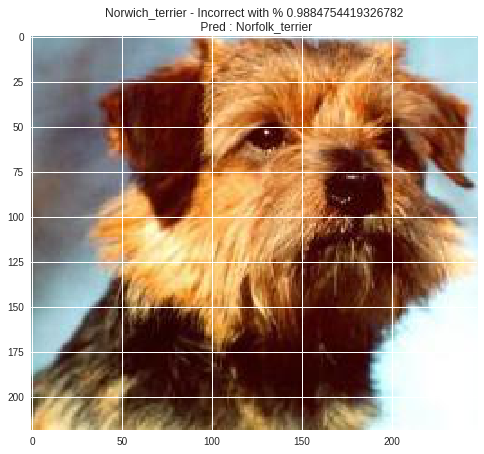

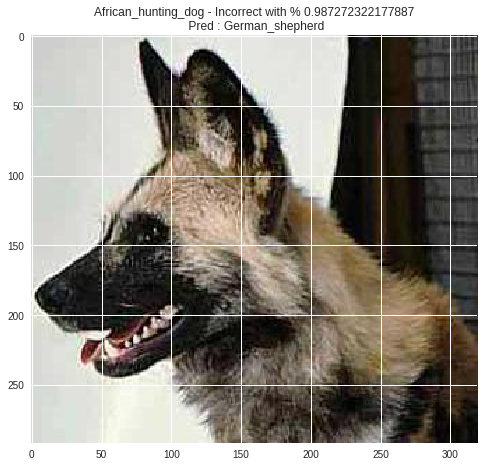

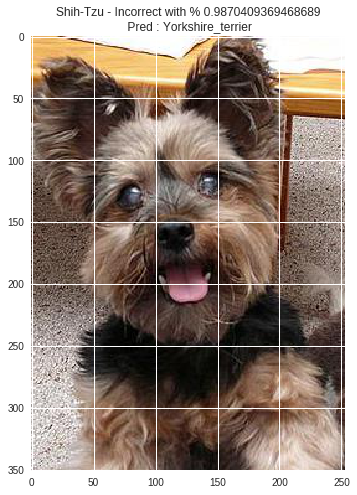

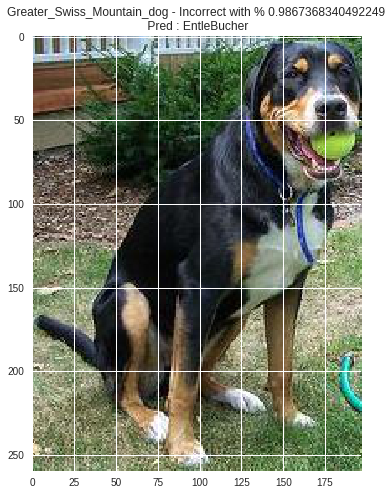

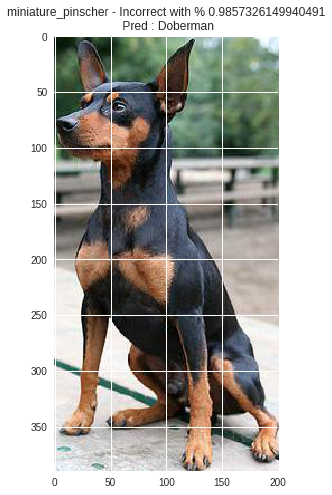

In [48]:
#Most wrong
%matplotlib inline
ds = resultset[np.logical_not(resultset['correct'])]
ds = ds.sort_values('maxval', ascending=False)
for index, line in ds[:10].iterrows():
    toopen = 'test/{}'.format(line.filepath)
    
    if toopen:
        plt.figure(figsize=(8,8))
        picture = imread(toopen)
        plt.imshow(picture)
        plt.title('{} - Incorrect with % {}\n Pred : {}'.format(line.breedname, line.maxval, indexlabel.get(line.predict)))
        plt.show()
    else:
        print('Picture not found')

    #print('{} - Correct with % {}'.format(line.breedname, line.maxval))